In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import colorbrewer
import cmocean

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join('/glade/scratch',os.environ['USER'],
                                            'dask/scheduler.json'))
client

Client Scheduler: tcp://10.148.7.209:8786 Dashboard: http://10.148.7.209:8787,Cluster Workers: 8 Cores: 32 Memory: 96.00 GB


In [3]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3','Q','PS','PBLH','T','U','V','U10','PSL','OMEGA']+tracer_3d

diri = os.path.join(dataroot,'orcas','cesm_flight_data')
model_files = [os.path.join(diri,'.'.join([case,os.path.basename(f)])) 
              for f in gv.flight_file]

obs = xr.open_mfdataset(gv.flight_file)
mdl = xr.open_mfdataset(model_files)

obs['GGALT'] = obs.GGALT * 1e-3
obs.GGALT.attrs['units'] = 'km'
obs = obs.drop(['UTC','DOY'])

mdl['GGALT'] = obs.GGALT.copy()
mdl['GGLAT'] = obs.GGLAT.copy()
mdl['GGLON'] = obs.GGLON.copy()
mdl = mdl.drop(['UTC','DOY'])
mdl.info()

xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	datetime64[ns] time(time) ;
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		C

### Apply a mask to avoid land and points north of latitude boundary

mask points over land

In [4]:
lat_rgn = [-90.,-44]
lon_rgn = [-180.,180.]

named_points = {
    'SCCI' : [-53.01062,-70.85168,42],
    'SCAR' : [-18.3483,-70.3386, 167],
    'SCTE' : [-41.438611, -73.0939, 294],
    'SCVD' : [-39.649722,-73.086111,59]}

airport_lon = np.array([v[1] for v in named_points.values()])
airport_lat = np.array([v[0] for v in named_points.values()])

def region_quality_mask(x,y,z):
    from earth_geometry import points_in_range

    #-- land_mask = within 10km of airport and below 4 km
    land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )

    #-- region_mask 
    region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )

    return ( land_mask & region_mask )


Verify application of mask: points in orange are included, points in blue have been removed

earth_geometry.py:57: RuntimeWarning: invalid value encountered in less_equal
  mask = np.array((haversine(clon,clat,plon.ravel(),plat.ravel()) <= range_km))
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


Text(0,0.5,u'Altitude')

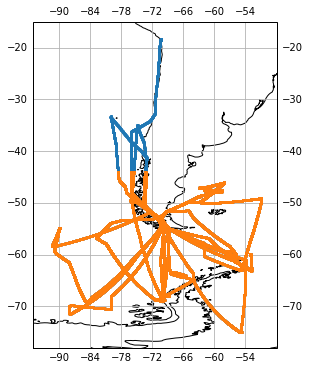

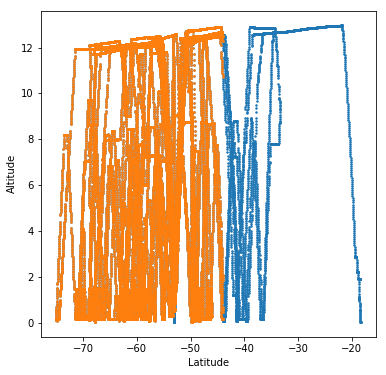

In [5]:
fig = plt.figure(figsize=(6,6))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=crs_latlon)
ax.set_extent([-95,-48,-78,-15],crs=crs_latlon)
ax.coastlines('50m')
ax.gridlines(draw_labels=True)

ax.plot(mdl.GGLON,mdl.GGLAT,'.',markersize=3,transform=crs_latlon)
ds = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
ax.plot(ds.GGLON,ds.GGLAT,'.',markersize=3,transform=crs_latlon)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(mdl.GGLAT,mdl.GGALT,'.',markersize=3)
ax.plot(ds.GGLAT,ds.GGALT,'.',markersize=3)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude')

Apply the mask

In [6]:
mdl = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
obs = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


### bin the data into altitude bins

In [7]:
%%time
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
alt_bin_c = np.vstack((alt_bins[0:-1],alt_bins[1:])).mean(axis=0)

groups = mdl.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
mdl_avg = groups.mean()
mdl_std = groups.std()

groups = obs.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
obs_avg = groups.mean()
obs_std = groups.std()
  
mdl_avg.info()

xarray.Dataset {
dimensions:
	GGALT_bins = 30 ;

variables:
	float64 GGALT_bins(GGALT_bins) ;
	float64 O2_OCN(GGALT_bins) ;
	float64 CO2_T09k(GGALT_bins) ;
	float64 aO2_GKA(GGALT_bins) ;
	float64 CO2_C15O(GGALT_bins) ;
	float64 CO2_LND(GGALT_bins) ;
	float64 U10(GGALT_bins) ;
	float64 CO2_T09(GGALT_bins) ;
	float64 PS(GGALT_bins) ;
	float64 CO2_T09b(GGALT_bins) ;
	float64 CO2_T09c(GGALT_bins) ;
	float64 CO2_T09d(GGALT_bins) ;
	float64 CO2_T09e(GGALT_bins) ;
	float64 CO2_T09f(GGALT_bins) ;
	float64 CO2_T09g(GGALT_bins) ;
	float64 CO2_T09h(GGALT_bins) ;
	float64 CO2_T09i(GGALT_bins) ;
	float64 CO2_T09j(GGALT_bins) ;
	float64 CO2_CROF(GGALT_bins) ;
	float64 CO2_T09l(GGALT_bins) ;
	float64 CO2_OCN(GGALT_bins) ;
	float64 CO2_CROT(GGALT_bins) ;
	float64 Pm(GGALT_bins) ;
	float64 OMEGA(GGALT_bins) ;
	float64 CO2_L14C(GGALT_bins) ;
	float64 Z3(GGALT_bins) ;
	float64 PBLH(GGALT_bins) ;
	float64 CO2_T09a(GGALT_bins) ;
	float64 CO2_CROO(GGALT_bins) ;
	float64 Q(GGALT_bins) ;
	float64 U(GGALT_bins

### Plot alt-bin averaged, normalized profiles

In [46]:
#normalize_alt = [12.,99.]
normalize_alt = [7.5,8.5]
normalize = lambda da: (da - 
                        da.where((da.GGALT_bins>normalize_alt[0]) &
                                 (da.GGALT_bins<normalize_alt[1])).mean())    
mdl_avg.GGALT_bins

<xarray.DataArray 'GGALT_bins' (GGALT_bins: 30)>
array([  0.125,   0.375,   0.625,   0.875,   1.25 ,   1.75 ,   2.25 ,   2.75 ,
         3.25 ,   3.75 ,   4.25 ,   4.75 ,   5.25 ,   5.75 ,   6.25 ,   6.75 ,
         7.25 ,   7.75 ,   8.25 ,   8.75 ,   9.25 ,   9.75 ,  10.25 ,  10.75 ,
        11.25 ,  11.75 ,  12.25 ,  12.75 ,  13.25 ,  13.75 ])
Coordinates:
  * GGALT_bins  (GGALT_bins) float64 0.125 0.375 0.625 0.875 1.25 1.75 2.25 ...

In [47]:
color = {'CO2_NOAA' : colorbrewer.singlehue('purple')[0],
         'CO2': colorbrewer.singlehue('blue')[4],
         'CO2_OCN': colorbrewer.singlehue('blue')[2],
         'CO2_FFF': colorbrewer.singlehue('red')[2],
         'CO2_LND': colorbrewer.singlehue('green')[1],
         'CO2_T09': colorbrewer.singlehue('red')[0],
         'CO2_L14C':colorbrewer.singlehue('orange')[4],
         'CO2_C15O':colorbrewer.singlehue('black')[0]}

alt_flux_tracers = ['CO2_L14C','CO2_T09','CO2_OCN','CO2_C15O']

[]

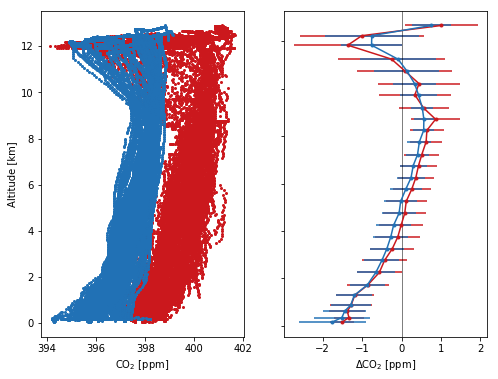

In [10]:
fig = plt.figure(figsize=(8.,6.))
vm = 'CO2'
vo = 'CO2_NOAA'
color_mdl = colorbrewer.singlehue('blue')[2]
color_obs = colorbrewer.singlehue('red')[2]

ax = fig.add_subplot(121)
sc = ax.plot(obs[vo],obs.GGALT,'.',markersize=4,color=color_obs)
sc = ax.plot(mdl[vm],mdl.GGALT,'.',markersize=4,color=color_mdl)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

ax = fig.add_subplot(122)
sc = ax.errorbar(normalize(obs_avg[vo]).values,
                 obs_avg.GGALT.values,
                 xerr=obs_std[vo].values,
                 fmt='.-',color=color_obs)

sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                 mdl_avg.GGALT.values,
                 xerr=mdl_std[vm].values,
                 fmt='.-',color=color_mdl)

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_yticklabels([])


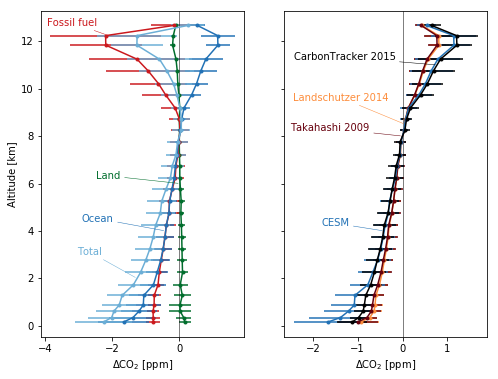

In [114]:
fig = plt.figure(figsize=(8.,6.))

#-- plot composition
ax = fig.add_subplot(121)
for vm in ['CO2_LND','CO2_FFF','CO2_OCN','CO2']:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])
    
ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

label = {'CO2_FFF':{'y':12.25,'xoff':-1.8,'yoff':0.4,'name':'Fossil fuel'},
         'CO2_LND':{'y':6,'xoff':-2.5,'yoff':0.2,'name':'Land'},
         'CO2_OCN':{'y':4,'xoff':-2.5,'yoff':0.4,'name':'Ocean'},         
         'CO2':{'y':2,'xoff':-1.8,'yoff':1,'name':'Total'}         
        }
for vm,lb in label.items():
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )

ax = fig.add_subplot(122)

for vm in alt_flux_tracers:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_yticklabels([])

label = {'CO2_L14C':{'y':8.5,'xoff':-2.5,'yoff':1,'name':'Landschutzer 2014'},
         'CO2_T09':{'y':8,'xoff':-2.5,'yoff':0.2,'name':'Takahashi 2009'},
         'CO2_C15O':{'y':11,'xoff':-3.2,'yoff':0.2,'name':'CarbonTracker 2015'},         
         'CO2_OCN':{'y':4,'xoff':-1.4,'yoff':0.2,'name':'CESM'}         
        }
for vm,lb in label.items():
    if vm not in alt_flux_tracers: continue
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )
plt.savefig(os.path.join(diro['fig'],'vertical-profile-flavors-alt-fluxes.pdf'),
           bbox_inches='tight',dpi=300)

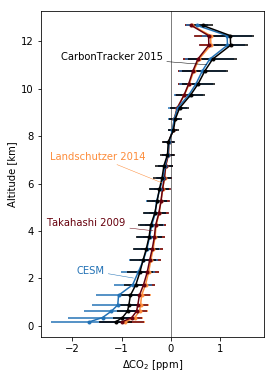

In [119]:
fig = plt.figure(figsize=(4.,6.))

ax = fig.add_subplot(111)

for vm in alt_flux_tracers:
    sc = ax.errorbar(normalize(mdl_avg[vm]).values,
                     mdl_avg.GGALT.values,
                     xerr=mdl_std[vm].values,
                     fmt='.-',color=color[vm])

ax.axvline(0.,linewidth=0.5,color='k')
ax.set_xlabel('$\Delta$CO$_2$ [ppm]')
ax.set_ylabel('Altitude [km]')

label = {'CO2_L14C':{'y':6,'xoff':-2.3,'yoff':1,'name':'Landschutzer 2014'},
         'CO2_T09':{'y':4,'xoff':-2.2,'yoff':0.2,'name':'Takahashi 2009'},
         'CO2_C15O':{'y':11,'xoff':-3.,'yoff':0.2,'name':'CarbonTracker 2015'},         
         'CO2_OCN':{'y':2,'xoff':-1.2,'yoff':0.2,'name':'CESM'}         
        }
for vm,lb in label.items():
    if vm not in alt_flux_tracers: continue
    x = np.interp(lb['y'],mdl_avg.GGALT.values,normalize(mdl_avg[vm]).values)
    ax.annotate(lb['name'], 
                xy=(x,lb['y']), 
                xytext=(x+lb['xoff'],lb['y']+lb['yoff']),
                color=color[vm],
                arrowprops=dict(color=color[vm],arrowstyle='-',linewidth=0.5),
                )
plt.savefig(os.path.join(diro['fig'],'vertical-profile-alt-fluxes.pdf'),
           bbox_inches='tight',dpi=300)

### did we capture zonal mean properties?

In [13]:
ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],transformed='so_ocean_mean')

ds = ds.sel(time=slice('2016-01-15','2016-02-29'))
ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds

<xarray.Dataset>
Dimensions:     (time: 46, zlev: 33)
Coordinates:
  * zlev        (zlev) float64 1.416e+04 1.315e+04 1.212e+04 1.107e+04 ...
  * time        (time) datetime64[ns] 2016-01-15 2016-01-16 2016-01-17 ...
Data variables:
    O2_OCN      (time, zlev) float64 57.6 58.45 59.8 61.43 63.29 66.15 68.97 ...
    CO2_CROF    (time, zlev) float64 42.16 43.06 43.95 44.81 45.53 45.97 ...
    CO2_LND     (time, zlev) float64 2.095 2.121 2.206 2.312 2.408 2.449 ...
    CO2_T09     (time, zlev) float64 -6.71 -6.859 -7.037 -7.242 -7.459 ...
    CO2_T09a    (time, zlev) float64 -6.556 -6.7 -6.873 -7.07 -7.279 -7.477 ...
    CO2_T09b    (time, zlev) float64 -6.524 -6.668 -6.843 -7.043 -7.255 ...
    CO2_T09c    (time, zlev) float64 -6.633 -6.78 -6.955 -7.156 -7.369 ...
    CO2_T09d    (time, zlev) float64 -6.617 -6.764 -6.94 -7.142 -7.357 ...
    CO2_T09e    (time, zlev) float64 -6.788 -6.938 -7.119 -7.327 -7.549 ...
    CO2_T09f    (time, zlev) float64 -6.804 -6.954 -7.135 -7.341 -7.561 ...

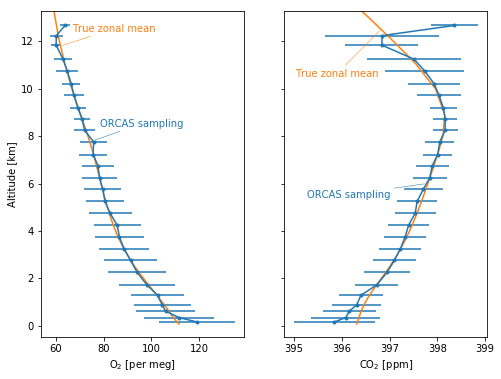

In [14]:
fig = plt.figure(figsize=(8.,6.))

vm = 'O2_OCN'
ax = fig.add_subplot(121)

sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,xerr=mdl_std[vm].values,fmt='.-')
xlm = ax.get_xlim()
ylm = ax.get_ylim()

p = ax.plot(ds[vm].mean(dim='time'),ds.zlev*1e-3)
ax.set_xlim(xlm)
ax.set_ylim(ylm)

ax.set_xlabel('O$_2$ [per meg]')
ax.set_ylabel('Altitude [km]')

y = 11.8
x = np.interp(y,ds.zlev[::-1]*1e-3,ds[vm].mean(dim='time')[::-1])
ax.annotate('True zonal mean', 
            xy=(x,y), 
            xytext=(x+5,y+0.6),
            color=p[0].get_color(),
            arrowprops=dict(color=p[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

y = 7.8
x = np.interp(y,mdl_avg.GGALT.values,mdl_avg[vm].values)
ax.annotate('ORCAS sampling', 
            xy=(x,y), 
            xytext=(x+3,y+0.6),
            color=sc[0].get_color(),
            arrowprops=dict(color=sc[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

vm = 'CO2'
ax = fig.add_subplot(122)

sc = ax.errorbar(mdl_avg[vm].values,mdl_avg.GGALT.values,xerr=mdl_std[vm].values,fmt='.-')
xlm = ax.get_xlim()
ylm = ax.get_ylim()

p = ax.plot(ds[vm].mean(dim='time'),ds.zlev*1e-3)
ax.set_xlim(xlm)
ax.set_ylim(ylm)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_yticklabels([])

y = 12.5
x = np.interp(y,ds.zlev[::-1]*1e-3,ds[vm].mean(dim='time')[::-1])
ax.annotate('True zonal mean', 
            xy=(x,y), 
            xytext=(x-1.8,y-2),
            color=p[0].get_color(),
            arrowprops=dict(color=p[0].get_color(),arrowstyle='-',linewidth=0.5),
            )

y = 6
x = np.interp(y,mdl_avg.GGALT.values,mdl_avg[vm].values)
ax.annotate('ORCAS sampling', 
            xy=(x,y), 
            xytext=(x-2.5,y-0.6),
            color=sc[0].get_color(),
            arrowprops=dict(color=sc[0].get_color(),arrowstyle='-',linewidth=0.5),
            )


plt.savefig(os.path.join(diro['fig'],'vertical-profile-zonal-representativeness.pdf'),
           bbox_inches='tight',dpi=300)

### Where is air coming from and how long did it take to get there?

In [15]:
for v in sorted(mdl.variables):
    if 'IDL' in v:
        print('{sname}: {long_name}'.format(sname=v,long_name=mdl[v].attrs['long_name']))

IDL_S001: Land (except Antarctic)
IDL_S002: Anarctica
IDL_S003: Ocean 90N-30S
IDL_S004: Ocean 30S-45S
IDL_S005: Ocean 45S-60S
IDL_S006: Ocean 60S-90S
IDL_T000: Age of air
IDL_T001: Age of air (Land, except Antarctic)
IDL_T002: Age of air (Anarctica)
IDL_T003: Age of air (Ocean 90N-30S)
IDL_T004: Age of air (Ocean 30S-45S)
IDL_T005: Age of air (Ocean 45S-60S)
IDL_T006: Age of air (Ocean 60S-90S)


Aggregate some of these tracers into a smaller set of regions

In [16]:
#-- southern ocean (S of 45S) plus antarctica
so_avg = mdl_avg.IDL_S005 + mdl_avg.IDL_S006 + mdl_avg.IDL_S002
so_std = np.sqrt(mdl_std.IDL_S005**2 + mdl_std.IDL_S006**2 + mdl_std.IDL_S002**2)

#-- ocean north of 45S
no_avg = mdl_avg.IDL_S003 + mdl_avg.IDL_S004
no_std = np.sqrt(mdl_std.IDL_S003**2 + mdl_std.IDL_S004**2)

#-- land (except antarctica)
land_avg = mdl_avg.IDL_S001
land_std = mdl_std.IDL_S001

#-- age 
age_total_avg = mdl_avg.IDL_T000 * 365.
age_total_std = mdl_std.IDL_T000 * 365.

alt = mdl_avg.GGALT

#### age of air tracers

Age of air tracer.  I screwed up the boundary conditions for the regional age tracers in `bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004`.  These should sum to the total age, but rather than specifying a surface boundary condition of 0, I mistakenely specified a within-region boundary condition of 1, and 0 out of the region.  Thus, it is possible to reconstruct total age + 1, but the regional age tracers are hard to interpret individually.

The total age (`IDL_T000`, $A$) should be the sum of the regional age tracers (`IDL_T00N`, $\phi$):

$A = \sum \phi$

and the regional age ($A_i$) should be the regional age tracer divided by the regional provenance fraction (`IDL_S00N`):

$A_i = \frac{\phi}{f_i}$

Demonstrate the consistency with total and regional summed age below.

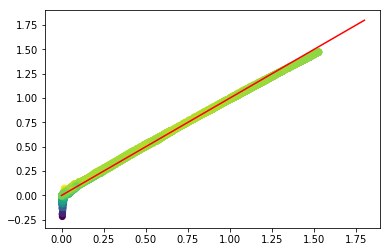

In [17]:
age = xr.full_like(mdl.IDL_T000,fill_value=0.)
frac = xr.full_like(mdl.IDL_T000,fill_value=0.)
for i in range(1,7):
    fraci = mdl['IDL_S{:03d}'.format(i)]
    agei = mdl['IDL_T{:03d}'.format(i)]
    frac += fraci
    age += agei

correction = 1.
    
plt.scatter(mdl.IDL_T000,age-correction,c=frac)
ylm = plt.gca().get_ylim()
plt.plot((0,1.8),(0,1.8),'r-')

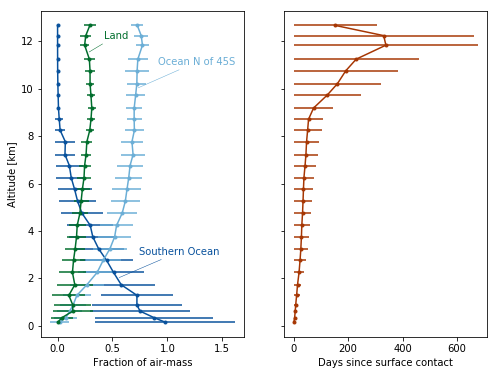

In [18]:
fig = plt.figure(figsize=(8.,6.))

color_so = colorbrewer.singlehue('blue')[1]
color_nh = colorbrewer.singlehue('blue')[4]
color_land = colorbrewer.singlehue('green')[1]
color_age = colorbrewer.singlehue('orange')[1]

ax = fig.add_subplot(121)
sc = ax.errorbar(so_avg.values,alt.values,
                 xerr=so_std.values,
                 fmt='.-',color=color_so)

sc = ax.errorbar(no_avg.values,alt.values,
                 xerr=no_std.values,
                 fmt='.-',color=color_nh)

sc = ax.errorbar(land_avg.values,alt.values,
                 xerr=land_std.values,
                 fmt='.-',color=color_land)


ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Fraction of air-mass')

#-- Label NH ocean
y = 10.
x = np.interp(y,alt.values,no_avg.values)
ax.annotate('Ocean N of 45S', 
            xy=(x,y), 
            xytext=(x+0.2,y+1),
            color=color_nh,
            arrowprops=dict(color=color_nh,arrowstyle='-',linewidth=0.5),
            )

#-- Label Southern Ocean
y = 2.
x = np.interp(y,alt.values,so_avg.values)
ax.annotate('Southern Ocean', 
            xy=(x,y), 
            xytext=(x+0.2,y+1),
            color=color_so,
            arrowprops=dict(color=color_so,arrowstyle='-',linewidth=0.5),
            )

#-- Label Land
y = 11.5
x = np.interp(y,alt.values,land_avg.values)
ax.annotate('Land', 
            xy=(x,y), 
            xytext=(x+0.15,y+0.6),
            color=color_land,
            arrowprops=dict(color=color_land,arrowstyle='-',linewidth=0.5),
            )


ax = fig.add_subplot(122)
sc = ax.errorbar(age_total_avg.values,alt.values,
                 xerr=age_total_avg.values,
                 fmt='.-',color=color_age)
ax.set_yticklabels([])
ax.set_xlabel('Days since surface contact')

plt.savefig(os.path.join(diro['fig'],'vertical-profile-air-provenance-age.png'),
           bbox_inches='tight',dpi=300)

### check sum of CO2 flavors against total

The nonlinear transport means that the sum cannot be constructed exactly. 

CO$_{2}$ tracers were initialized with a constant mixing ratio of 360 ppm, thus I would expect to require that offset to match the total CO$_{2}$.  

Text(0,0.5,u'$\\sum$ CO$_2$')

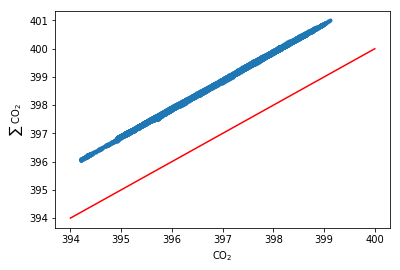

In [19]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+360.,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

That doesn't quite work.  Let's compute the optimal offset.

In [20]:
offset = (mdl.CO2 - (mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF)).mean().values
offset

array(358.119006699359)

Why is that different from 360.?  Perhaps there was an issue with precision?  Does the ratio with respect to 360 appear meaningful?

In [21]:
offset/360.

0.99477501860933049

Text(0,0.5,u'$\\sum$ CO$_2$')

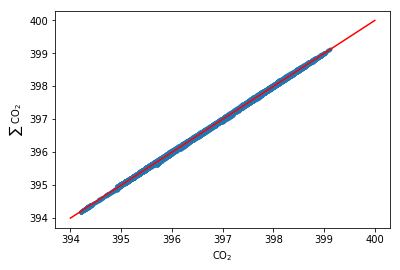

In [22]:
plt.plot(mdl.CO2,mdl.CO2_OCN+mdl.CO2_LND+mdl.CO2_FFF+offset,'.')
plt.plot((394,400),(394,400),'r-')
plt.gca().set_xlabel('CO$_2$')
plt.gca().set_ylabel('$\sum$ CO$_2$')

### Methane distributions

Load up some data from NOAA ESRL: marine boundary layer CH4 obs.

https://www.esrl.noaa.gov/gmd/ccgg/mbl/data.php

In [23]:
import pandas
mblch4 = pandas.read_table('data/ch4_GHGreference.664228799_zonal.txt',comment='#',header=None,
                     names=('year','month','day','decimal_date','value','uncertainty'),
                     delim_whitespace=True).to_xarray()
mblch4

<xarray.Dataset>
Dimensions:       (index: 385)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    year          (index) int64 2009 2009 2009 2009 2009 2009 2009 2009 2009 ...
    month         (index) int64 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 ...
    day           (index) int64 1 8 16 23 31 8 15 23 2 10 18 25 2 9 17 25 2 ...
    decimal_date  (index) float64 2.009e+03 2.009e+03 2.009e+03 2.009e+03 ...
    value         (index) float64 1.735e+03 1.732e+03 1.731e+03 1.729e+03 ...
    uncertainty   (index) float64 1.041 1.026 1.079 1.183 1.292 1.367 1.379 ...

Fit a harmonic function to the data: 

$y=a+b∗t+c∗cos(2\pi t+d)$

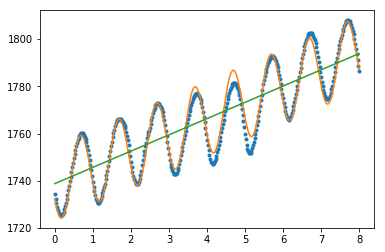

In [260]:
from scipy.optimize import curve_fit

#-- define the function
func = lambda t,a,b,c,d: a + b * t + c * np.cos(2.*np.pi*t + d)

#-- define time axis
tmbl = mblch4.decimal_date-mblch4.decimal_date[0]

#-- fit parameters
abcd, pcov = curve_fit(func,tmbl,mblch4.value.values)

#-- just the trend
abcd_nocycle = abcd.copy()
abcd_nocycle[2:] = 0.

plt.plot(tmbl,mblch4.value,'.')
plt.plot(tmbl,func(tmbl,*abcd))
plt.plot(tmbl,func(tmbl,*abcd_nocycle))

Compute the offset necessary to match data in 2016

In [261]:
offset = func(tmbl[np.where(mblch4.decimal_date == 2016.)[0]],*abcd_nocycle) - abcd[0]
offset.values

array([ 48.19744829])

#### bin data by altitude and flight number

In [292]:
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
binflt = lambda ds: ds.groupby('flt').mean()
ch4 = obs.groupby_bins('GGALT',alt_bins).apply(binflt)

Compute the date of each flight in DOY

In [242]:
flight_date = [obs.time[np.where(obs.flt == flt)[0][0]] for flt in ch4.flt]
t = np.array([(d - np.datetime64('2016-01-01')) /  np.timedelta64(1,'D') for d in flight_date])
t

array([ 14.54136574,  17.62087963,  20.62157407,  22.63534722,
        24.51486111,  24.69726852,  29.67458333,  35.62435185,
        38.63013889,  40.54946759,  42.62701389,  47.58825231,
        48.65328704,  49.87365741,  52.98488426,  54.6062963 ,
        55.6875463 ,  59.58048611])

Plot the flight data in the context of the seasonal cycle inferred from MBL data

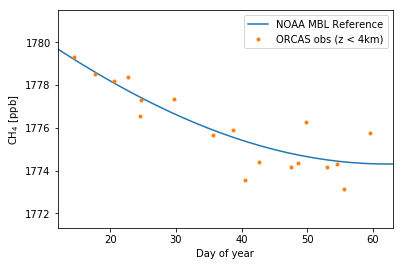

In [311]:
yearfrac = np.arange(0,366,1)/365.
abcd_notrend = abcd.copy()
abcd_notrend[1] = 0.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(yearfrac*365.,func(yearfrac,*abcd)+50.,label='NOAA MBL Reference')
ax.plot(t,ch4.CH4_NOAA.where(ch4.GGALT <= 4.).mean(dim='GGALT_bins'),'.',label='ORCAS obs (z < 4km)')

ylm = ax.get_ylim()
ax.set_xlim((12,63))
ax.set_ylim((ylm[0],1781.5))

ax.set_xlabel('Day of year')
ax.set_ylabel('CH$_4$ [ppb]')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.savefig(os.path.join(diro['fig'],'ch4-seasonal-cycle.pdf'))

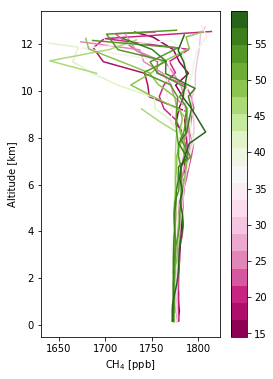

In [310]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)

cmap = cm = plt.get_cmap('PiYG',lut=len(t)+1) 
cNorm  = colors.Normalize(vmin=t[0], vmax=t[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []

for i in range(len(ch4.flt)):
    colorVal = scalarMap.to_rgba(t[i])
    p = ax.plot(ch4.CH4_NOAA[:,i],ch4.GGALT[:,i],
                color=colorVal)

cb = plt.colorbar(scalarMap,ticks=np.arange(15,60,5))

ax.set_xlabel('CH$_4$ [ppb]')
ax.set_ylabel('Altitude [km]')

plt.savefig(os.path.join(diro['fig'],'ch4-profile-by-date.pdf'))

### calibrate vertical gradient

In [27]:
ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],transformed='so_ocean_mean')

#ds = ds.sel(time=slice('2015-01-01','2016-02-29'))
ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds

<xarray.Dataset>
Dimensions:     (time: 3347, zlev: 33)
Coordinates:
  * zlev        (zlev) float64 1.416e+04 1.315e+04 1.212e+04 1.107e+04 ...
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Data variables:
    O2_OCN      (time, zlev) float64 8.963 8.99 9.111 9.818 11.27 13.62 ...
    CO2_CROF    (time, zlev) float64 4.6 4.807 5.156 5.605 5.989 6.223 6.297 ...
    CO2_LND     (time, zlev) float64 0.3145 0.3642 0.5007 0.6551 0.7804 ...
    CO2_T09     (time, zlev) float64 -0.7934 -0.8375 -0.9395 -1.106 -1.29 ...
    CO2_T09a    (time, zlev) float64 -0.7796 -0.823 -0.9232 -1.086 -1.265 ...
    CO2_T09b    (time, zlev) float64 -0.7665 -0.8095 -0.9094 -1.073 -1.254 ...
    CO2_T09c    (time, zlev) float64 -0.7865 -0.8302 -0.9314 -1.096 -1.277 ...
    CO2_T09d    (time, zlev) float64 -0.78 -0.8235 -0.9245 -1.089 -1.272 ...
    CO2_T09e    (time, zlev) float64 -0.8002 -0.8447 -0.9476 -1.116 -1.303 ...
    CO2_T09f    (time, zlev) float64 -0.8068 -0.8514 -0.9545 -

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


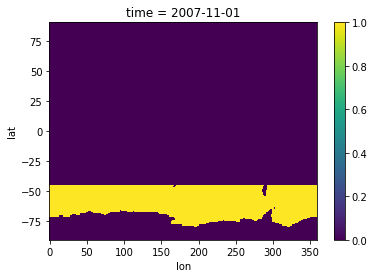

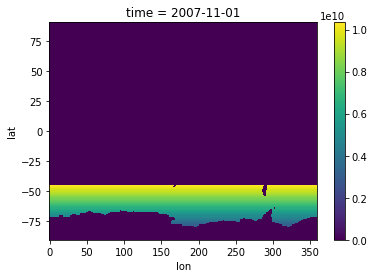

In [28]:
grid = xr.open_dataset('/glade/p/work/mclong/grids/f09_f09.nc')
landfrac = grid.LANDFRAC.isel(time=0)
area = grid_tools.compute_grid_area(grid.lon.values,grid.lat.values)
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.).where(landfrac.lat<-44.).fillna(0.)
plt.figure()
rmask.plot()
area = rmask * area
plt.figure()
area.plot()

convert the flux fields into regional integrals in Pg C

In [29]:
co2_ocn = ['CO2_OCN', 'CO2_T09', 'CO2_L14C',
           'CO2_T09a', 'CO2_T09b', 'CO2_T09c', 
           'CO2_T09d', 'CO2_T09e', 'CO2_T09f', 'CO2_T09g', 
           'CO2_T09h', 'CO2_T09i', 'CO2_T09j', 'CO2_T09k', 
           'CO2_T09l',  
           'CO2_CRPO', 'CO2_CROO', 'CO2_C15O']

sfint = xr.Dataset()
for v in co2_ocn:
    sfint[v] = ds['SF'+v] * area.sum() * 12.e-15
    sfint[v].attrs['units'] = 'Pg C yr$^{-1}$'

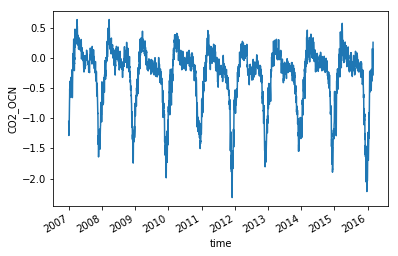

In [30]:
sfint.CO2_OCN.plot()

### plot regional mean fluxes

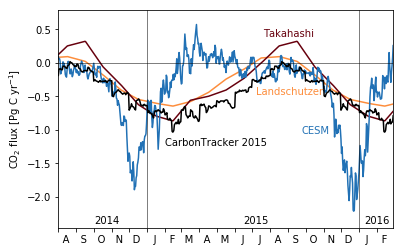

In [318]:
from datetime import datetime
import matplotlib.dates as mdates
months = mdates.MonthLocator()

fig = plt.figure()
ax = fig.add_subplot(111)

label = {}
sel = {'time':slice('2015-01-01',None)}
for vm in alt_flux_tracers:
    ax.plot(sfint.time,sfint[vm],'-',color=color[vm])

ax.axhline(0,linewidth=0.5,color='k')

ylm = ax.get_ylim()
bot = np.diff(ylm)*0.02 + ylm[0]
ax.text(pandas.Timestamp(2014,10,1),bot,'2014')
ax.text(datetime(2015,6,15),bot,'2015')
ax.text(datetime(2016,1,10),bot,'2016')

x = np.datetime64('2015-12-01')
y = np.interp(x.astype(float),sfint.time.values.astype(float),sfint.CO2_OCN.values)
ax.text(x-np.timedelta64(20,'D'),y,'CESM',
        color = color['CO2_OCN'],
        horizontalalignment='right')

x = np.datetime64('2015-12-01')
y = np.interp(x.astype(float),sfint.time.values.astype(float),
              sfint.CO2_L14C.values)
ax.text(x-np.timedelta64(30,'D'),y+0.1,'Landschutzer',
        color = color['CO2_L14C'],
        horizontalalignment='right')

x = np.datetime64('2015-09-01')
y = np.interp(x.astype(float),
              sfint.time.values.astype(float),
              sfint.CO2_T09.values)
ax.text(x-np.timedelta64(0,'D'),y+1.1,'Takahashi',
        color = color['CO2_T09'],
        horizontalalignment='center')

if 'CO2_C15O' in alt_flux_tracers:
    x = np.datetime64('2015-02-01')
    y = np.interp(x.astype(float),
                  sfint.time.values.astype(float),
                  sfint.CO2_C15O.values)
    ax.text(x-np.timedelta64(0,'D'),y-0.6,'CarbonTracker 2015',
            color = color['CO2_C15O'],
            horizontalalignment='left')

datemin = datetime(2014,8,1)
datemax = datetime(2016,2,29)
ax.set_xlim(datemin, datemax)
ax.set_ylabel('CO$_2$ flux [Pg C yr$^{-1}$]')

ax.xaxis.set_major_locator(months)
ax.set_xticklabels(['     '+d.strftime('%b')[0] for d in mdates.num2date(ax.get_xticks())])

ax.axvline(datetime(2015,1,1),linewidth=0.5,color='k')
ax.axvline(datetime(2016,1,1),linewidth=0.5,color='k')

plt.savefig(os.path.join(diro['fig'],'southern-ocean-flux-timeseries-2014-2016.pdf'))

#### Compute the vertical gradient

In [319]:
#nx_lower_trop = np.where((1000<=ds.zlev)&(ds.zlev<=2000.))[0]
#nx_upper_trop = np.where((7000<=ds.zlev)&(ds.zlev<=8000.))[0]

nx_lower_trop = np.where((0<=ds.zlev)&(ds.zlev<=2000.))[0]
nx_upper_trop = np.where((3000<=ds.zlev)&(ds.zlev<=4000.))[0]


vg = xr.Dataset()
for v in co2_ocn:
    vg[v] = (ds[v][:,nx_lower_trop].mean(dim='zlev') - 
             ds[v][:,nx_upper_trop].mean(dim='zlev'))
vg

<xarray.Dataset>
Dimensions:   (time: 3347)
Coordinates:
  * time      (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Data variables:
    CO2_OCN   (time) float64 -0.5331 -0.5427 -0.545 -0.5313 -0.5373 -0.5464 ...
    CO2_T09   (time) float64 -0.2468 -0.2606 -0.2524 -0.2443 -0.2553 -0.2653 ...
    CO2_L14C  (time) float64 -0.2614 -0.2697 -0.2595 -0.2494 -0.2576 -0.2638 ...
    CO2_T09a  (time) float64 -0.1736 -0.1868 -0.1827 -0.1794 -0.1898 -0.1996 ...
    CO2_T09b  (time) float64 -0.2154 -0.2248 -0.214 -0.2039 -0.21 -0.2149 ...
    CO2_T09c  (time) float64 -0.2102 -0.2237 -0.2176 -0.2119 -0.2226 -0.2325 ...
    CO2_T09d  (time) float64 -0.2311 -0.2427 -0.2332 -0.2241 -0.2326 -0.2401 ...
    CO2_T09e  (time) float64 -0.2834 -0.2975 -0.2872 -0.2767 -0.288 -0.2982 ...
    CO2_T09f  (time) float64 -0.2625 -0.2785 -0.2716 -0.2645 -0.2779 -0.2905 ...
    CO2_T09g  (time) float64 -0.3199 -0.3343 -0.3219 -0.309 -0.3206 -0.331 ...
    CO2_T09h  (time) float64 -0.2782 -0.2965 -0.290

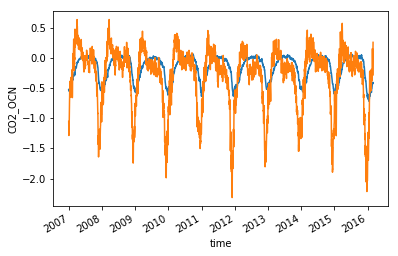

In [320]:
vg.CO2_OCN.plot()
sfint.CO2_OCN.plot()

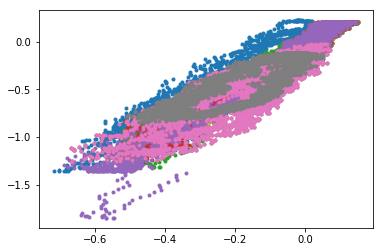

In [321]:
xstack = []
ystack = []
for v in co2_ocn:
    plt.plot(vg[v],pandas.ewma(sfint[v].to_series(),30),'.')
    xstack.append(vg[v])
    ystack.append(pandas.ewma(sfint[v].to_series(),30))
xstack = np.vstack(xstack)
ystack = np.vstack(ystack)

In [322]:
ewma = lambda da,tau: xr.DataArray.from_series(pandas.ewma(da.to_series(),tau))
vg_stack = np.vstack([vg[v] for v in co2_ocn])
sfint_ewma_stack = lambda tau: np.vstack([ewma(sfint[v],tau) for v in co2_ocn])
objective_func = lambda tau: (1.-np.corrcoef(vg_stack.ravel(),sfint_ewma_stack(tau).ravel())[0,1])**2

In [323]:
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')
tau = optimize.fmin(objective_func,40)
tau

Optimization terminated successfully.
         Current function value: 0.002579
         Iterations: 21
         Function evaluations: 42


array([ 17.64715576])

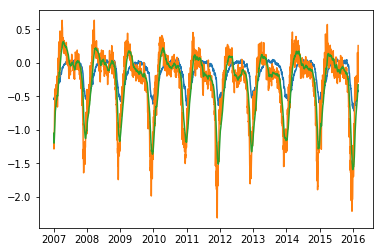

In [324]:
fig = plt.figure()

plt.plot(vg.time,vg.CO2_OCN,'-')
plt.plot(vg.time,sfint.CO2_OCN,'-')
plt.plot(vg.time,ewma(sfint.CO2_OCN,tau),'-')

[-0.37150989  2.65653871]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     38.35
Date:                Fri, 09 Feb 2018   Prob (F-statistic):           6.00e-09
Time:                        17:14:07   Log-Likelihood:                 31.772
No. Observations:                 144   AIC:                            -59.54
Df Residuals:                     142   BIC:                            -53.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3715     

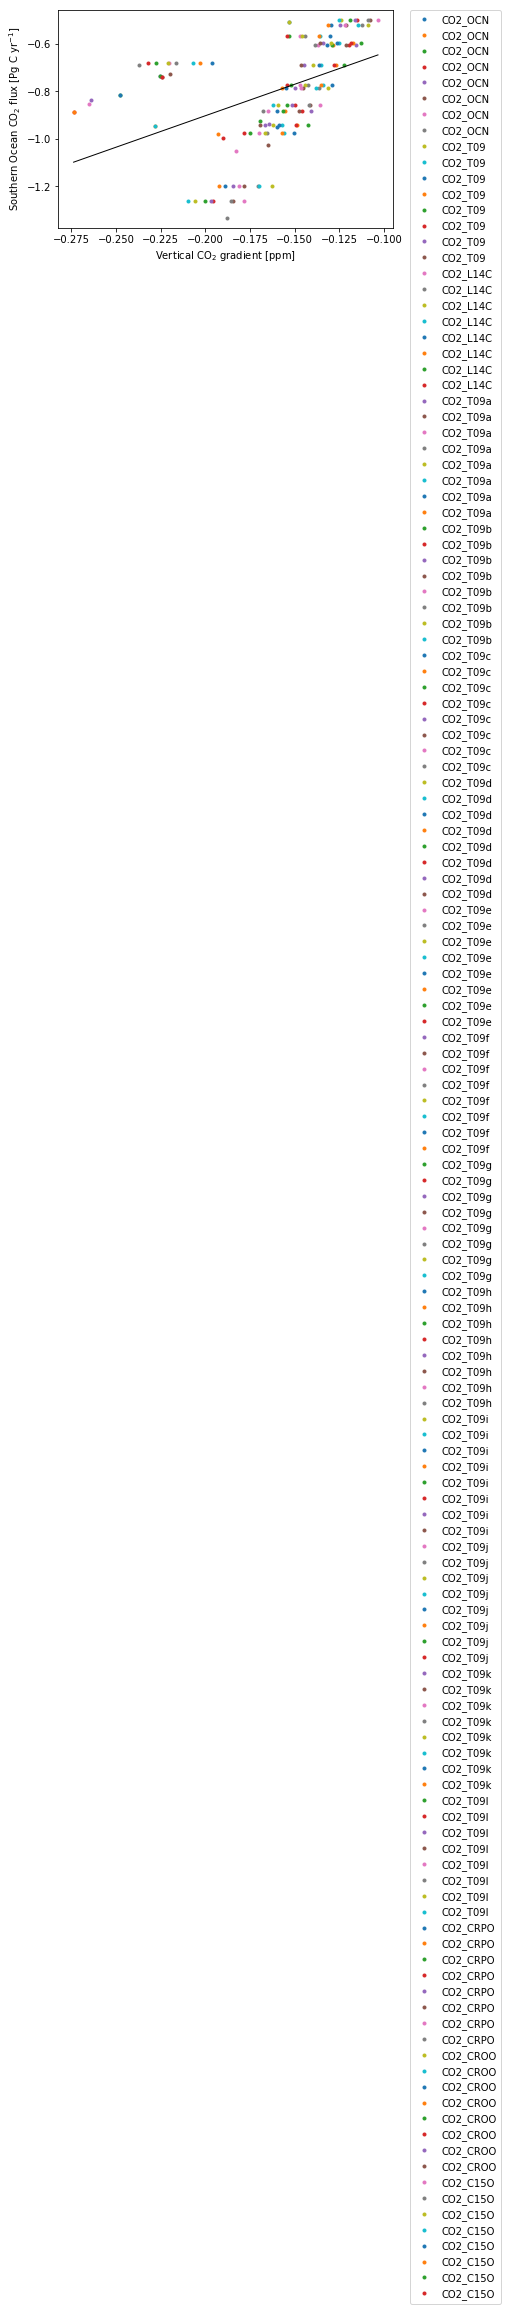

In [344]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.array([])
y = np.array([])
for v in co2_ocn:
    for yr in range(2008,2016):
        xi = vg[v].sel(time=slice('%d-01-15'%yr,'%d-02-28'%(yr+1))).mean()        
        yi = sfint[v].sel(time=slice('%d-12-01'%yr,'%d-01-31'%(yr+1))).mean()
        x = np.append(x,xi)
        y = np.append(y,yi)    
        ax.plot(xi,yi,'.',label=v)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())

s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')    

ax.set_xlabel('Vertical CO$_2$ gradient [ppm]')
ax.set_ylabel('Southern Ocean CO$_2$ flux [Pg C yr$^{-1}$]')
plt.savefig(os.path.join(diro['fig'],'calibrate-vertical-gradient.pdf'))

In [342]:
x.shape

(144,)

### O2-CO2 ratios

In [327]:
%%time
alt_bins = np.arange(0.,9.,1.)
lat_bins = np.arange(-75.,-30.,5.)
binlat = lambda ds: ds.groupby_bins('GGLAT',lat_bins).mean()

mdl_bin = mdl.groupby_bins('GGALT',alt_bins).apply(binlat)
obs_bin = obs.groupby_bins('GGALT',alt_bins).apply(binlat)

mdl_bin = mdl_bin.where(obs.N2O_QCLS>326)
obs_bin = obs_bin.where(obs.N2O_QCLS>326)
mdl_bin

CPU times: user 46.1 s, sys: 732 ms, total: 46.8 s
Wall time: 50.8 s


In [328]:
lat_bins

array([-75., -70., -65., -60., -55., -50., -45., -40., -35.])

[ 3847.08886719   -11.05006365]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 6.889e+06
Date:                Fri, 09 Feb 2018   Prob (F-statistic):               0.00
Time:                        17:01:18   Log-Likelihood:            -1.7442e+06
No. Observations:              731584   AIC:                         3.488e+06
Df Residuals:                  731582   BIC:                         3.488e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3847.088

Text(398.7,-550,u'slope = -2.31 mol O$_2$:mol CO$_2$')

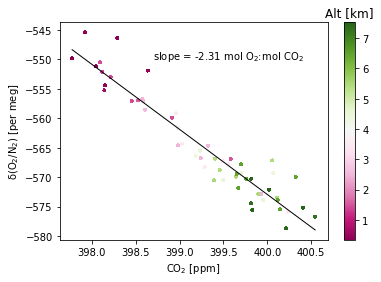

In [329]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = obs_bin.CO2_NOAA.values.ravel()
y = obs_bin.O2_AO2.values.ravel()
z = obs_bin.GGALT.values.ravel()
k = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z))
x = x[k]
y = y[k]
z = z[k]

sc = ax.scatter(x,y,c=z,cmap='PiYG',s=4)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('$\delta$(O$_2$/N$_2$) [per meg]')

cb = plt.colorbar(sc)
cb.ax.set_title('Alt [km]')

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())

s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')

ax.text(398.7, -550., 'slope = {:0.2f} mol O$_2$:mol CO$_2$'.format(fitted.params[1]*0.2095))

[ 7224.54307569   -17.96146783]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 9.805e+06
Date:                Fri, 09 Feb 2018   Prob (F-statistic):               0.00
Time:                        17:01:42   Log-Likelihood:            -1.9550e+06
No. Observations:              731584   AIC:                         3.910e+06
Df Residuals:                  731582   BIC:                         3.910e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7224.543

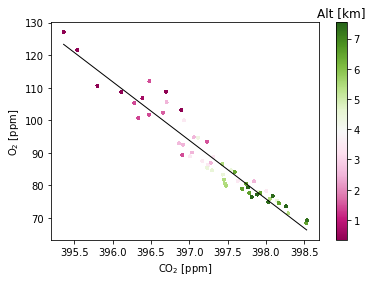

In [330]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = mdl_bin.CO2.values.ravel()
y = mdl_bin.O2_OCN.values.ravel()
z = mdl_bin.GGALT.values.ravel()
k = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z))
x = x[k]
y = y[k]
z = z[k]

sc = ax.scatter(x,y,c=z,cmap='PiYG',s=4)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('O$_2$ [ppm]')

cb = plt.colorbar(sc)
cb.ax.set_title('Alt [km]')

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())

s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')

#ax.text(399., -550., 'slope = {:0.2f} mol O$_2$:mol CO$_2$'.format(fitted.params[1]))


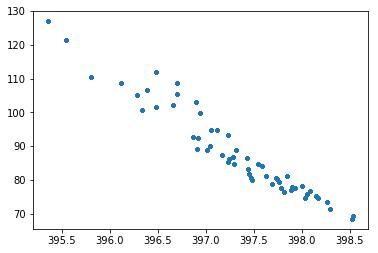

In [331]:
plt.plot(x,y,'.')